## <font color='navy'> Examen 2. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> Modelos de Clasificación

Luis Fernando Márquez Bañuelos | 744489

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn import discriminant_analysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [3]:
len(data[data['diabetes'] == 1]), len(data[data['diabetes'] == 0])

(8500, 91500)

Nuestros datos estan bastante desbalanceados, lo cual puede afectar el entrenamiento y prueba de los modelos, para lidiar con esto utilizaremos `stratify`, esto permite tener una proporción similar de clases entre el set de entrenamiento y el de prueba.

## <font color='navy'> Explicación de variables

1. **`gender`** (Categórica):  
   - **Descripción**: Género del paciente.  
   - **Valores posibles**: `Female` (mujer), `Male` (hombre).  

2. **`age`** (Numérica):  
   - **Descripción**: Edad del paciente en años.  

3. **`hypertension`** (Binaria):  
   - **Descripción**: Indica si el paciente tiene hipertensión.  
   - **Valores**: `0` (no), `1` (sí).  

4. **`heart_disease`** (Binaria):  
   - **Descripción**: Indica si el paciente tiene enfermedades cardíacas.  
   - **Valores**: `0` (no), `1` (sí).  

5. **`smoking_history`** (Categórica):  
   - **Descripción**: Historial de tabaquismo del paciente.  
   - **Valores posibles**:  
     - `never`: Nunca ha fumado.  
     - `former`: Exfumador.  
     - `current`: Fumador actual.  
     - `No Info`: Datos no proporcionados.  
     - `ever`: Alguna vez ha fumado (poco común).  
     - `not current`: No fuma actualmente.  

6. **`bmi`** (Numérica):  
   - **Descripción**: Índice de Masa Corporal (BMI, por sus siglas en inglés).  

7. **`diabetes`** (Binaria):  
   - **Descripción**: Diagnóstico de diabetes (variable objetivo).  
   - **Valores**: `0` (no tiene diabetes), `1` (tiene diabetes).  

## <font color='navy'> Funciones

In [4]:
def histograma_variables(data: pd.DataFrame, numerical_features: list):
    for i in range(len(numerical_features)):
        plt.hist(data[numerical_features[i]], bins = 20, color = 'skyblue', edgecolor = 'black')
        plt.title(numerical_features[i])
        plt.show()

def boxplot_variables(data: pd.DataFrame, numerical_features: list):
    fig, axes = plt.subplots(1, len(numerical_features), figsize=(12, 6))
    for ax, feature in zip(axes, numerical_features):
        ax.boxplot(data[feature].dropna())
        ax.set_title(feature)
    plt.suptitle("Boxplots of Numerical Features")
    plt.tight_layout()
    plt.show()

def scatterplots(df: pd.DataFrame, num_features: list, target: str):
    for i in num_features:
        plt.scatter(df[i],df[target], c = 'skyblue')
        plt.title(f'{i} vs {target}')
        plt.xlabel(i)
        plt.ylabel(target)
        plt.show()

def bivariado(df: pd.DataFrame, num_features: list, target: str, bins: int = 10):
    for feature in num_features:
        df[f'{feature}_bins'] = pd.qcut(df[feature], q=bins, labels=False, duplicates='drop') + 1
        grouped = df.groupby(f'{feature}_bins').mean()
        plt.plot(grouped[feature], grouped[f'{target}'], marker='o', c='navy')
        plt.title(f'{feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(f'{target}')
        plt.grid()
        plt.show()

In [5]:
class ClassificationModels:
    def __init__(self, X, y, params_log = None, params_knn = None, params_red = None):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, stratify=y, test_size=0.2, random_state=42)

        self.params_log = params_log or {
            'poly__degree': [1, 2, 3],
            'logreg__penalty': [None, 'l2'],
            'logreg__C': [0.01, 0.1, 1]
            }

        self.params_knn = params_knn or {
            'knn__n_neighbors': range(1, 30),
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']
            }

        self.params_red = params_red or {
            'red__hidden_layer_sizes': [(5,5,5), (50,50), (100,), (10,10)],
            'red__activation': ['tanh', 'relu', 'logistic'],
            'red__alpha': [0.1, 0.01]
            }

    def histograma(self, probabilidades: np.ndarray, modelo: str):
        juntar = pd.DataFrame({
        'real': self.y_test,
        'probabilidades': probabilidades
        })
        plt.figure(figsize=(10, 5))
        plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
        plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
        plt.title(f'Histograma de probabilidades de {modelo}')
        plt.xlabel('Probabilidad')
        plt.ylabel('Densidad')
        plt.legend()
        plt.show()
        print()
    
    def calibracion(self, probabilidades: np.ndarray, modelo: str, bins = 10):
        calibracion = pd.DataFrame({
        'target': self.y_test, 
        'probabilidades': probabilidades
        })

        calibracion['bins'] = pd.qcut(calibracion['probabilidades'], q=bins, labels=False, duplicates='drop') + 1
        grouped = calibracion.groupby('bins').mean()
        
        plt.figure(figsize=(10, 5))
        plt.plot(grouped.probabilidades, grouped.target, marker="o", c = 'skyblue')
        plt.plot(grouped.probabilidades, grouped.probabilidades, marker='o', c="indianred")
        plt.xlabel("Probabilidad")
        plt.ylabel("Real")
        plt.title(f'Gráfica de calibración de {modelo}')
        plt.grid()
        plt.show()

    def roc_curve(self, probabilidades: np.ndarray, modelo: str):
        fpr, fnp, _ = roc_curve(y_score=probabilidades, y_true=self.y_test)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, fnp, c='skyblue')
        plt.plot([0, 1], [0, 1], c='indianred')
        plt.title(f'Curva ROC de {modelo}')
        plt.show()

    def evaluar_modelo(self, probabilidades, modelo):
        self.calibracion(probabilidades, modelo)
        self.roc_curve(probabilidades, modelo)
        self.histograma(probabilidades, modelo)


    def logistic_regression(self) -> float:
        pipeline = Pipeline([
        ('poly', PolynomialFeatures(include_bias=False)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ])

        random_search = RandomizedSearchCV(pipeline, param_distributions=self.params_log, 
                                           n_iter=10, cv=5, scoring='roc_auc', random_state=42)
        random_search.fit(self.X_train, self.y_train)

        degree = random_search.best_params_['poly__degree']
        probabilidades = random_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        feature_names = random_search.best_estimator_.named_steps['poly'].get_feature_names_out(self.X_train.columns)
        coefs = random_search.best_estimator_.named_steps['logreg'].coef_[0]
        df_coef = pd.DataFrame({
            'variable': feature_names, 
            'coeficiente': coefs})
        
        df_coef = df_coef.sort_values(by='coeficiente', ascending=False)
        display(df_coef)

        self.evaluar_modelo(probabilidades, modelo=f'regresión logística grado {degree}')
        return auc

    def discriminant_analysis(self) -> float:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', discriminant_analysis.LinearDiscriminantAnalysis())
        ])

        pipeline.fit(self.X_train, self.y_train)
        probabilidades = pipeline.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.evaluar_modelo(probabilidades, modelo='discriminante lineal')
        return auc
    
    def knn_classification(self) -> float:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())  
        ])

        random_search = RandomizedSearchCV(estimator=pipeline, 
                                   param_distributions=self.params_knn, 
                                   n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc', random_state=42)
        random_search.fit(self.X_train, self.y_train)

        opt_nn = random_search.best_params_['knn__n_neighbors']
        probabilidades = random_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)
        
        self.evaluar_modelo(probabilidades, modelo=f'knn con {opt_nn} vecinos')
        return auc
    
    def red_neuronal(self) -> float:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('red', MLPClassifier(max_iter=1000, random_state=42))
        ])

        grid_search = GridSearchCV(estimator=pipeline, param_grid=self.params_red, cv=5, n_jobs=-1, scoring='roc_auc')
        grid_search.fit(self.X_train, self.y_train)

        probabilidades = grid_search.predict_proba(self.X_test)[:, 1]
        auc = roc_auc_score(y_score=probabilidades, y_true=self.y_test)

        self.evaluar_modelo(probabilidades, modelo='red neuronal')
        return auc
    
    def run_models(self):
        """
        Función que corre los 4 modelos de clasificación y devuelve un DataFrame con los resultados
        """
        modelos = [
            'Regresión Logística',
            'KNN',
            'Análisis Discriminante',
            'Red Neuronal'
        ]

        aucs = [
            self.logistic_regression(),
            self.knn_classification(),
            self.discriminant_analysis(),
            self.red_neuronal()
        ]
        aucs = np.array(aucs)
        resultados = pd.DataFrame({
            'modelos': modelos,
            'auc': aucs,
            'gini': (2 * aucs) -1
        })
        return resultados

## <font color='navy'> Limpieza de Datos

In [6]:
data = pd.get_dummies(data, columns=['gender', 'smoking_history'])
target = 'diabetes'
data.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,True,False,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,True,False,False,True,False,False,False,False,False
2,28.0,0,0,27.32,0,False,True,False,False,False,False,False,True,False
3,36.0,0,0,23.45,0,True,False,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,False,True,False,False,True,False,False,False,False


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age                          100000 non-null  float64
 1   hypertension                 100000 non-null  int64  
 2   heart_disease                100000 non-null  int64  
 3   bmi                          100000 non-null  float64
 4   diabetes                     100000 non-null  int64  
 5   gender_Female                100000 non-null  bool   
 6   gender_Male                  100000 non-null  bool   
 7   gender_Other                 100000 non-null  bool   
 8   smoking_history_No Info      100000 non-null  bool   
 9   smoking_history_current      100000 non-null  bool   
 10  smoking_history_ever         100000 non-null  bool   
 11  smoking_history_former       100000 non-null  bool   
 12  smoking_history_never        100000 non-null  bool   
 13  

In [8]:
len(data[data['age'] == data['age'].max()])

5621

In [9]:
len(data[(data['age'] == data['age'].max()) & (data['diabetes'] == 1)])

1024

Hay 5621 personas con 80 años o más (suponiendo que la edad tope ahí), de las cuales 1024 tienen diabetes, lo cual es bastante eleveado. Además solo hay 8500 personas con diabetes de las 100,000 en total, por lo que una octava parte de las personas con diabetes tiene 80 años y una quinta parte de personas con 80 años tiene diabetes; por lo tanto es conveniente agregar una variable que identifique si la persona tiene 80 años, ya que es un factor importante para saber si alguien tiene diabetes.

## <font color='navy'> Modelos Base

In [10]:
data['is_80'] = (data['age'] >= 80).astype(int)
data

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,is_80
0,80.0,0,1,25.19,0,True,False,False,False,False,False,False,True,False,1
1,54.0,0,0,27.32,0,True,False,False,True,False,False,False,False,False,0
2,28.0,0,0,27.32,0,False,True,False,False,False,False,False,True,False,0
3,36.0,0,0,23.45,0,True,False,False,False,True,False,False,False,False,0
4,76.0,1,1,20.14,0,False,True,False,False,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,True,False,False,True,False,False,False,False,False,1
99996,2.0,0,0,17.37,0,True,False,False,True,False,False,False,False,False,0
99997,66.0,0,0,27.83,0,False,True,False,False,False,False,True,False,False,0
99998,24.0,0,0,35.42,0,True,False,False,False,False,False,False,True,False,0


In [11]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [12]:
models = ClassificationModels(X, y)

,variable,coeficiente
0,age,0.754540
17,age bmi,0.718087
3,bmi,0.629773
18,age gender_Female,0.336403
19,age gender_Male,0.316991
...,...,...
63,bmi is_80,-0.209638
16,age heart_disease,-0.270230
15,age hypertension,-0.316734
53,bmi^2,-0.434138


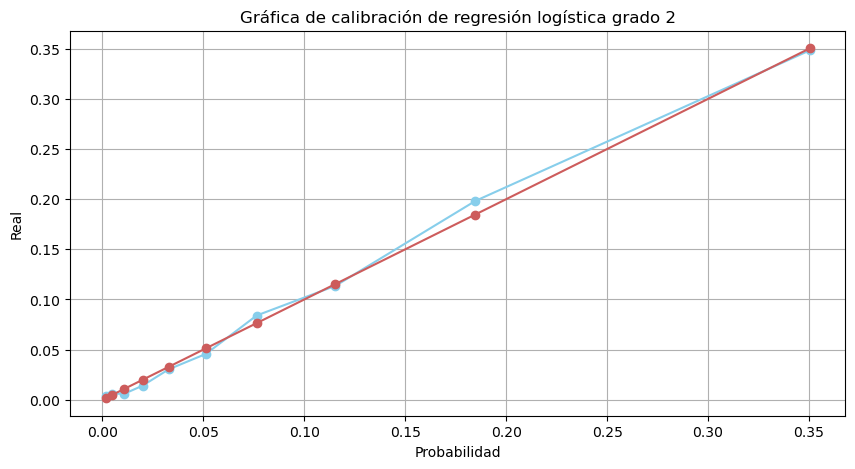

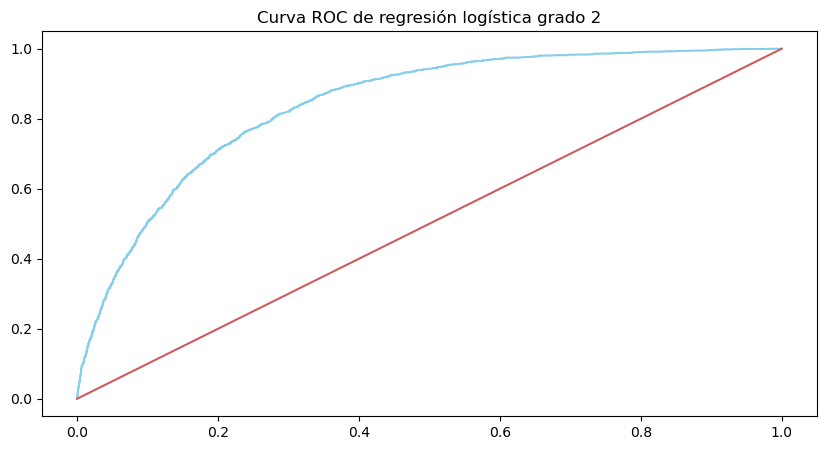

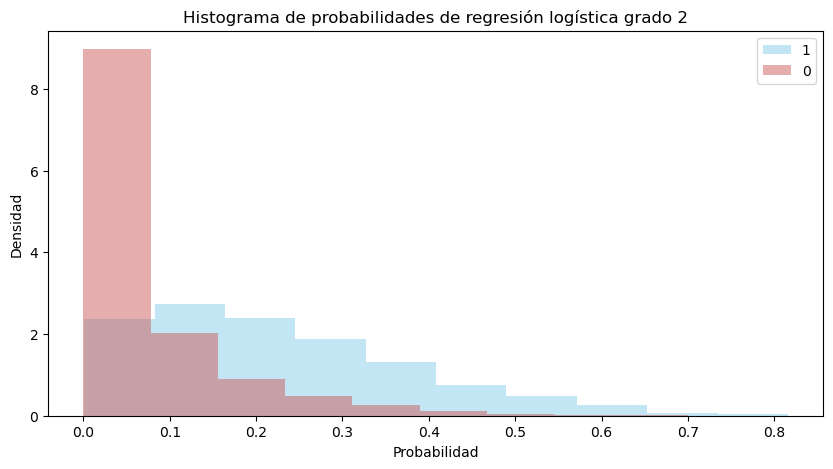

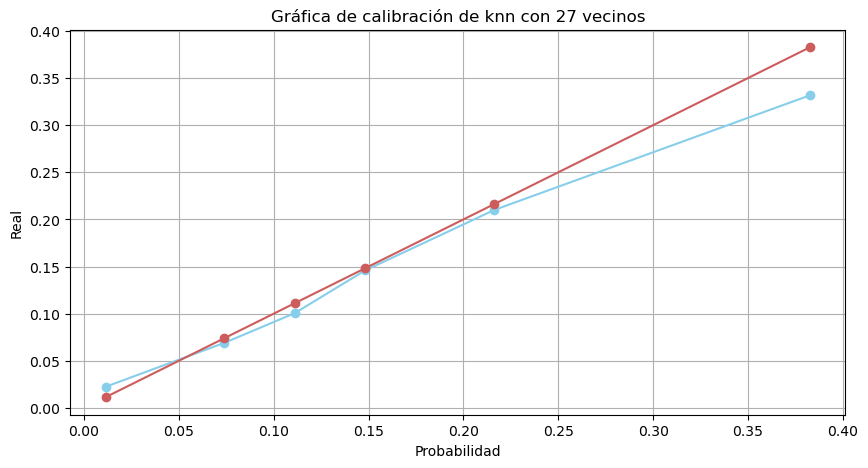

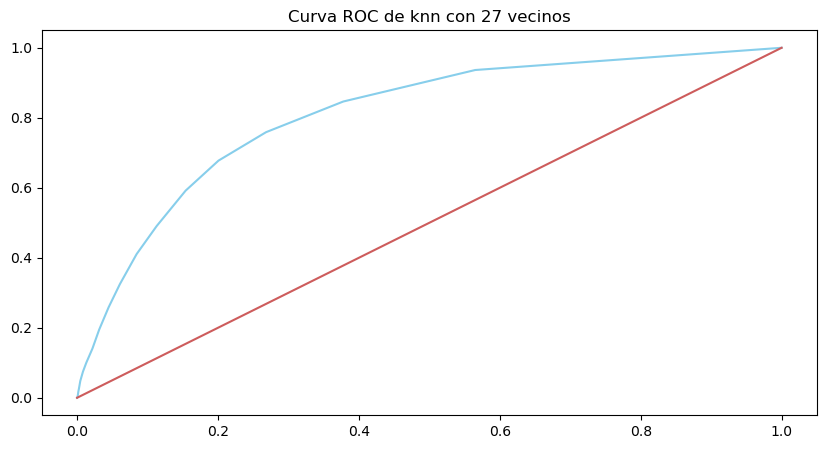

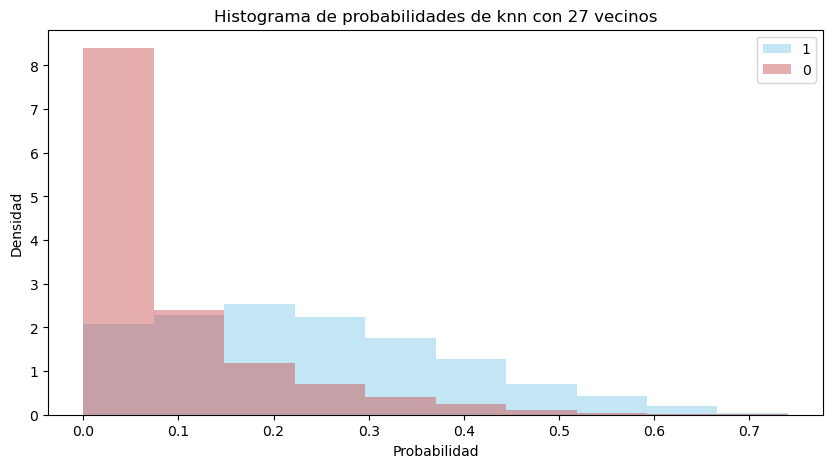

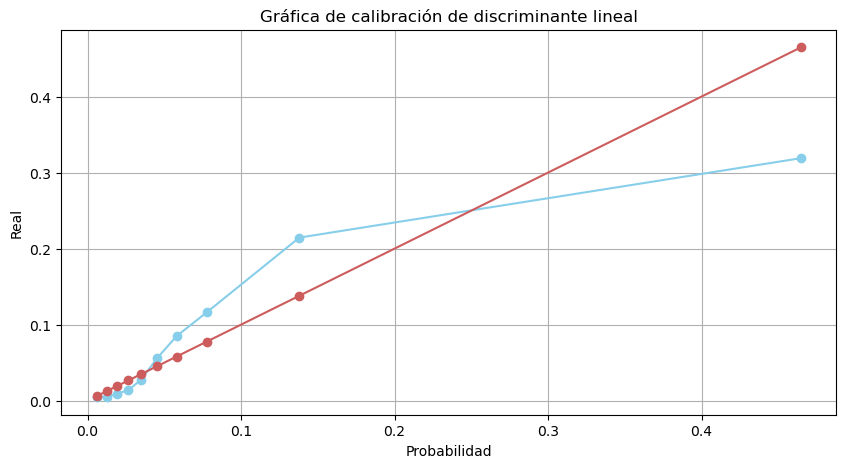

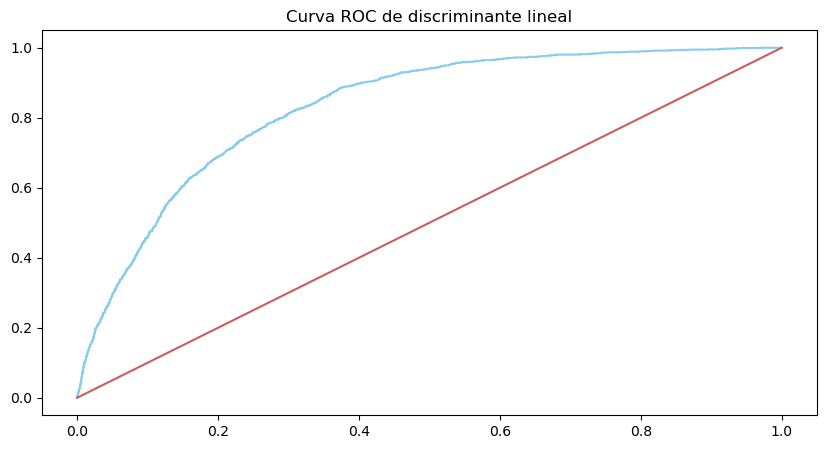

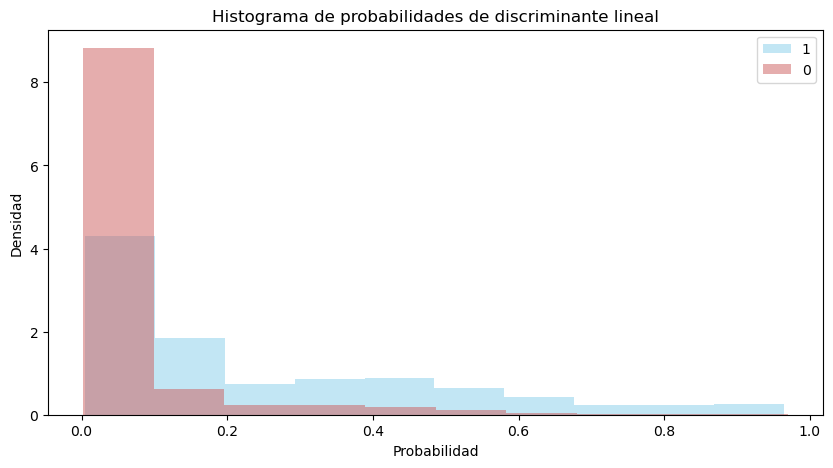

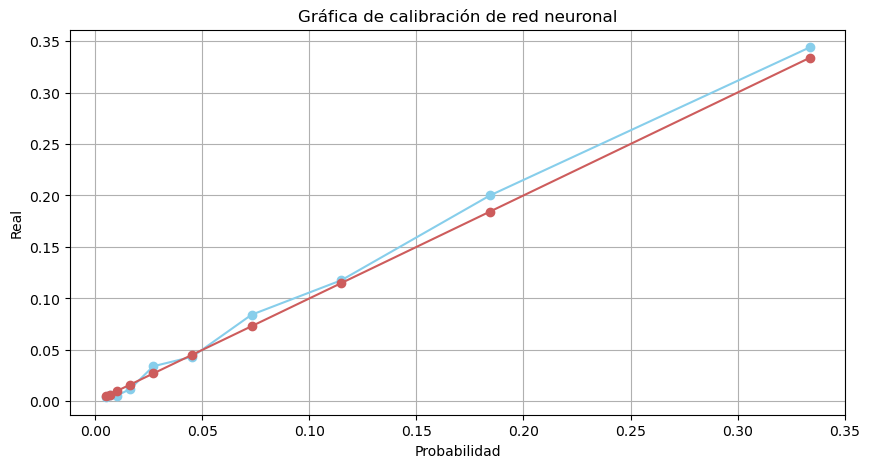

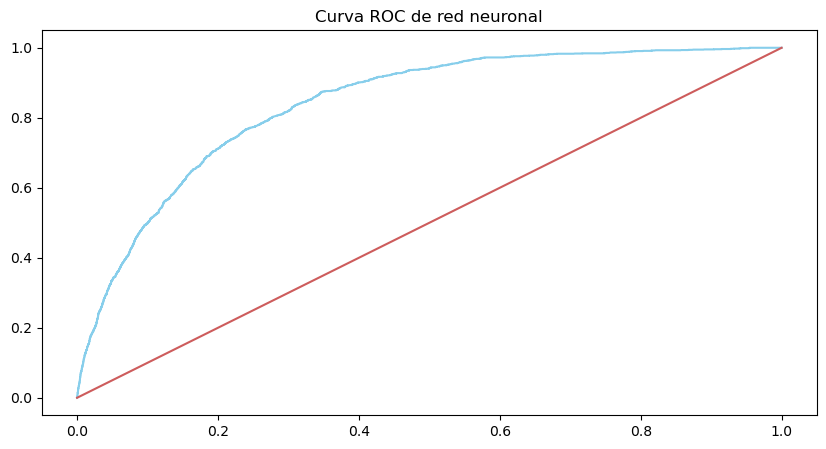

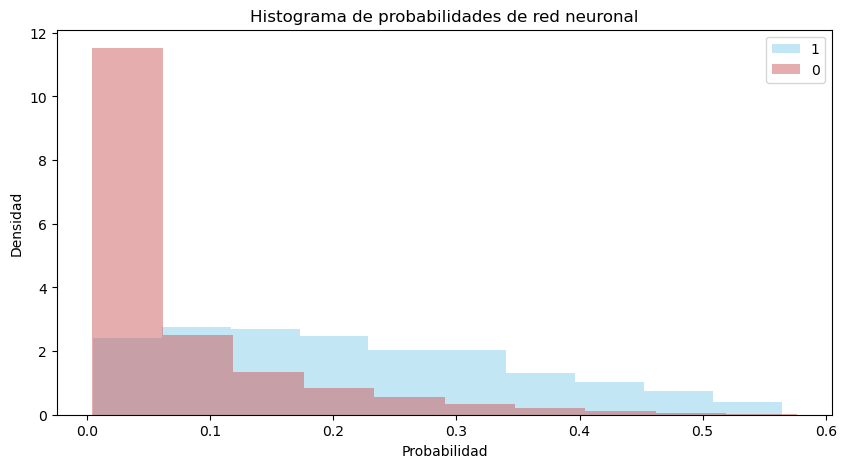

,modelos,auc,gini
0,Regresión Logística,0.840216,0.680432
1,KNN,0.808996,0.617991
2,Análisis Discriminante,0.830913,0.661826
3,Red Neuronal,0.840028,0.680056


In [13]:
models.run_models()

Una vez utilizados todos los modelos vemos que el mejor hasta el momento es la regresión logística de polinomio de grado 2, con un AUC de 0.8402, lo que quiere decir que tiene una buena capacidad para distinguir entre las clases. Esto se debe a que hay un 84.02% de probabilidad de que la probabilidad predicha para alguien con diabetes sea mayor a la de alguien sin diabetes. Además la red neuronal tuvo un desempeño muy similar siendo ligeramente inferior a la regresión logística, por lo que depués de realizar el feature engineering puede llegar a ser un modelo más adecuado.

Por parte de los coeficientes obtenidos de la regresión logística, al estar escalados los datos se pueden interpretar directamente, por lo tanto los más importantes son age, age * bmi y bmi. Lo que los coeficientes nos dicen es que el log-odds de que la persona tenga diabetes aumenta 0.75 por cada año que aumenta la persona, 0.71 para age * mbi y 0.62 para bmi.

Algo importante a resaltar son los histogramas de todos los modelos, donde bastantes predicciones de las personas con diabetes son bajas, lo cual no es algo bueno, y claramente tiene bastante margen de mejora, mientras que las personas que no tienen diabetes parecen estar bastante bien calsificadas, pues en su mayoría tienen una predicción bastante baja. Esto quiere decir que hay que concentrarse en que pasa con quienes si tienen diabetes para clasificarlos mejor.

## <font color='navy'> Feature Engineering

### <font color='navy'> Análisis de Datos

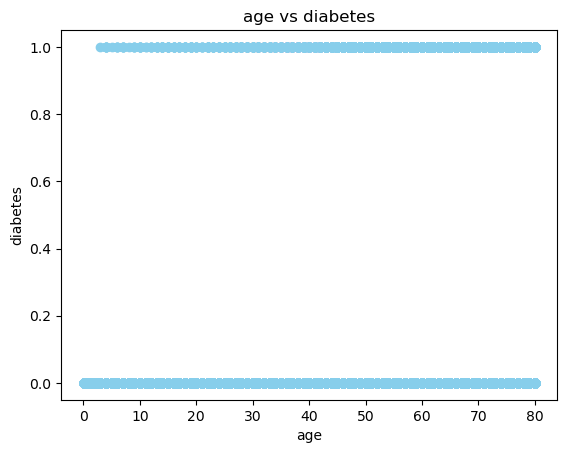

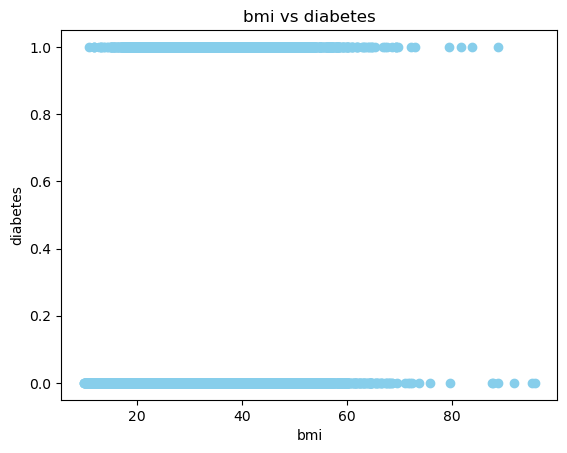

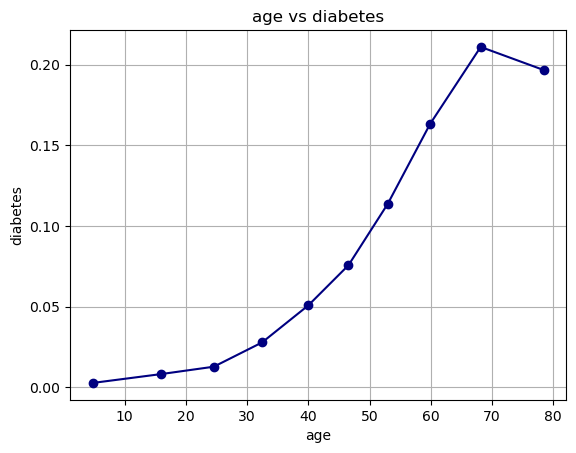

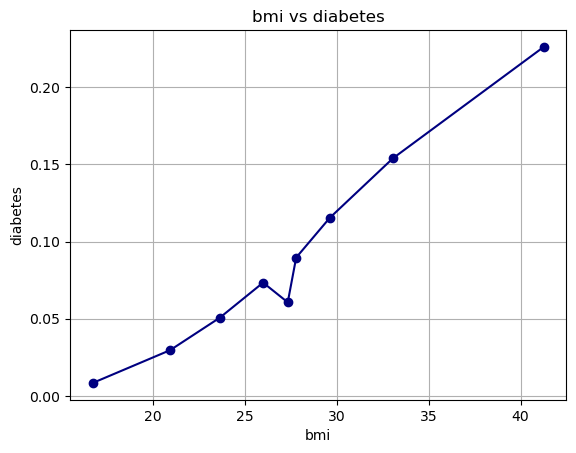

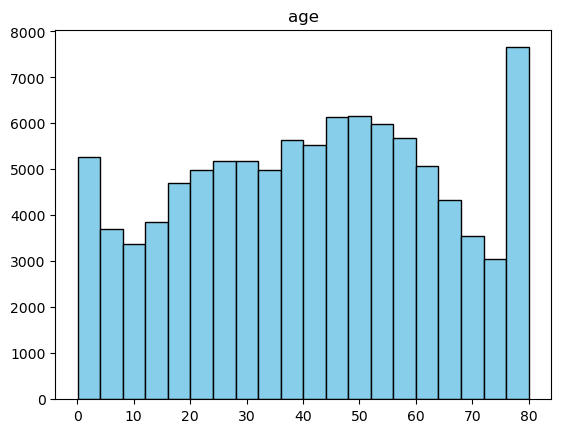

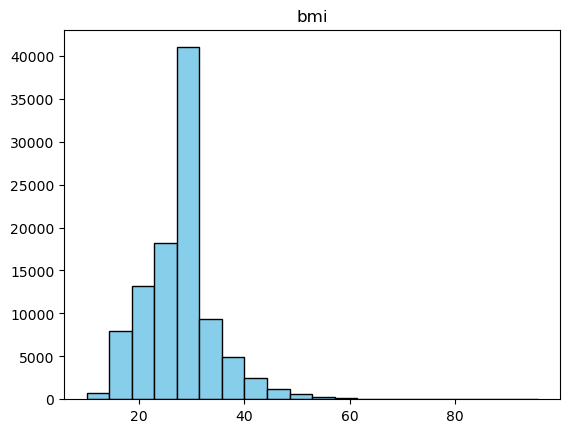

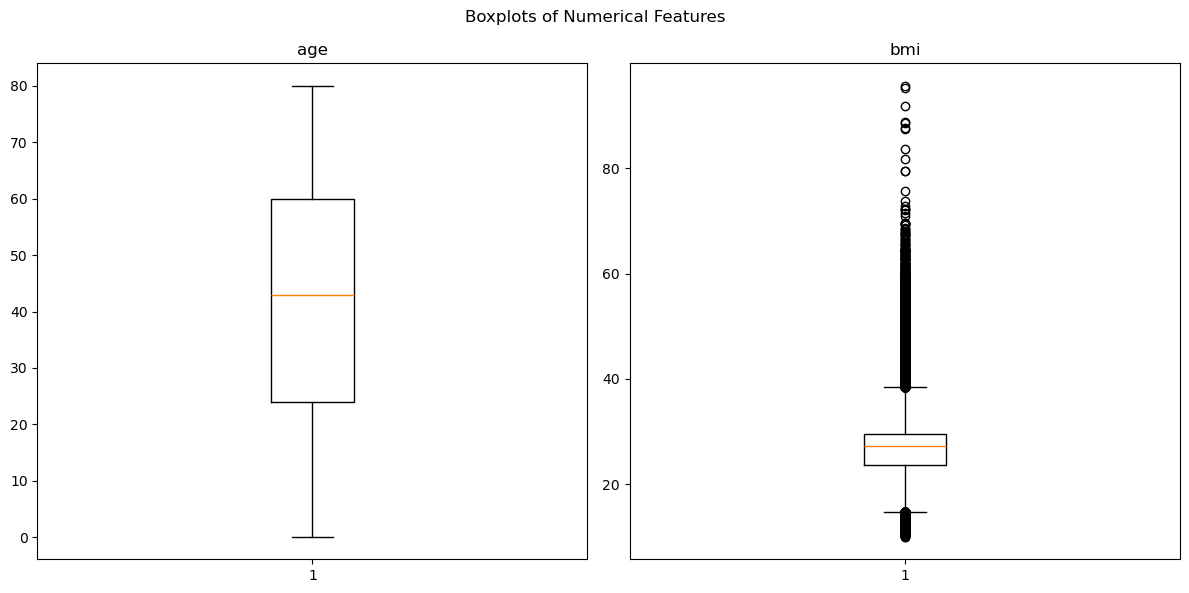

In [14]:
numerical_features = ['age', 'bmi']

scatterplots(data, numerical_features, target)
bivariado(data, numerical_features, target)

histograma_variables(data, numerical_features)
boxplot_variables(data, numerical_features)

Con el scatterplot de nuestros datos es que parecería que la edad no influye tanto en la posibilidad de tener diabetes, esto al menos de manera visual, pasa lo mismo con el bmi, donde incluso existe gente con el bmi muy alto que no tiene diabetes.

Sin embargo en el análisis bivariado vemos que la posibilidad de tener diabetes tiende a subir conforme aumenta la edad y el bmi. La edad parece que aumenta de forma exponencial ligeramente y cae al final, esto también puede explicarse que personas con diabetes puede ser difícil que lleguen a vivir tanto timepo por las complicaciones médicas que conlleva tener la enfermedad. En cuanto al bmi aumenta de forma lineal, es decir, a mayor bmi aumenta la probabilidad de tener diabetes.

Por lo tanto, el análisis bivariado nos da más información que el scatterplot en nuestros datos. La distibución de la edad es relativamente uniforme, esto nos dice que este dato está equilibrado en nuestro dataset. Por parte del bmi, parece concentrarse mucho alrededor de 30, esto puede ser importante.

El boxplot no indica que las edades se reparten relativamente parejas, sin embargo, el bmi no, ya que el rango intercuartílico es muy chico y cuenta con muchos outliers, por lo que una transformación logarítmica puede ser de ayuda. Además usar age * bmi puede ser útil ya que tuvo un coeficiente alto en la regresión logística realizada anteriormente, por lo que vale la pena hacer la transformación.

### <font color='navy'> Creación de variables

In [15]:
# Creación de variables
data['age_bmi'] = data['age'] * data['bmi']
data['age/bmi'] = data['age'] / data['bmi']

# Transformaciones 
data['log_bmi'] = np.log(1 + data['bmi'])
data['age^15'] = data['age'] ** 1.5

### <font color='navy'> Probar modelos

In [16]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

,variable,coeficiente
222,age_bmi log_bmi,0.474748
193,smoking_history_never age^15,0.443297
16,age_bmi,0.432802
23,age bmi,0.432802
224,age/bmi^2,0.281562
...,...,...
56,hypertension age/bmi,-0.352219
104,gender_Female age_bins,-0.386306
74,heart_disease age/bmi,-0.474294
223,age_bmi age^15,-0.531003


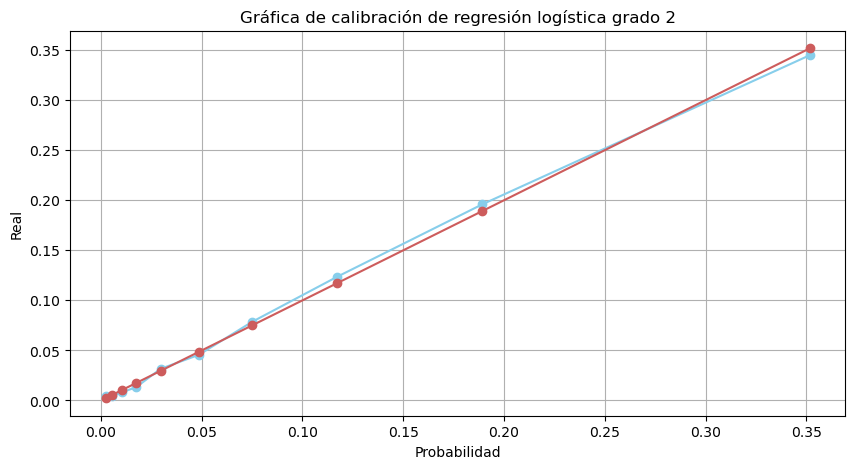

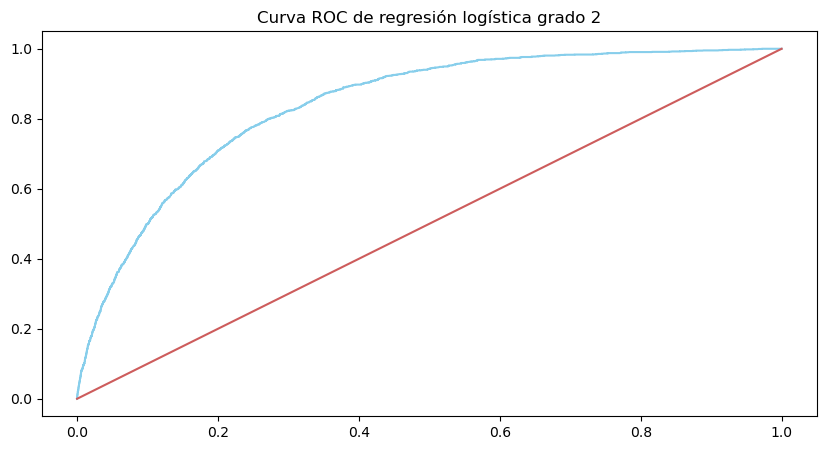

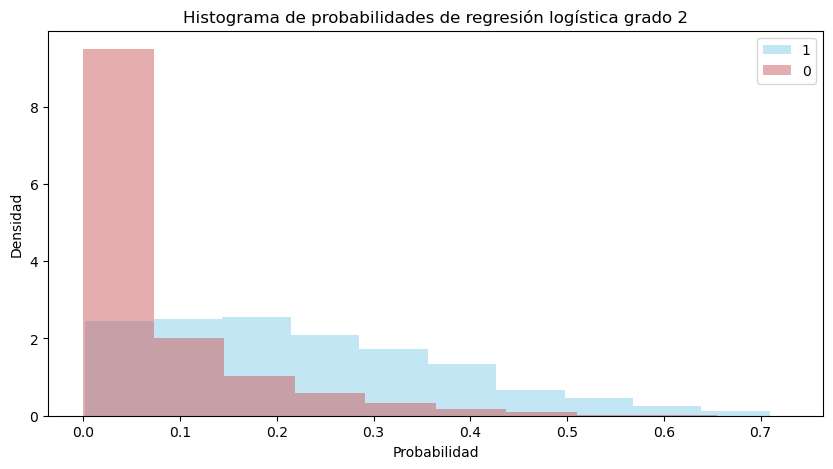

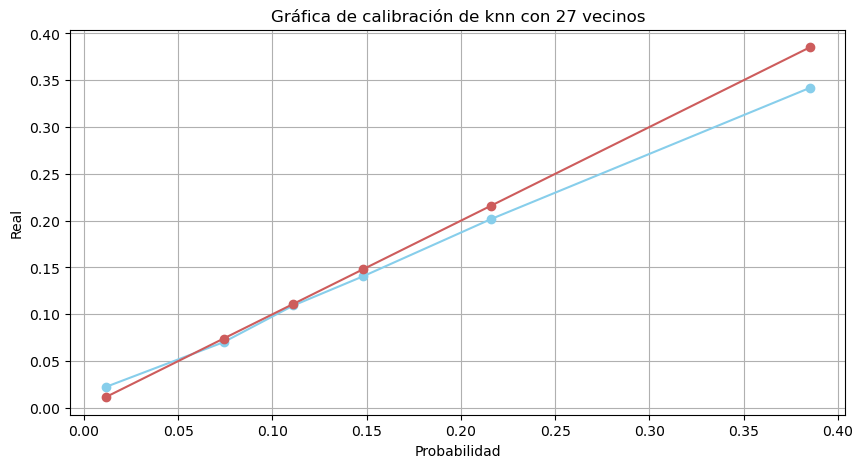

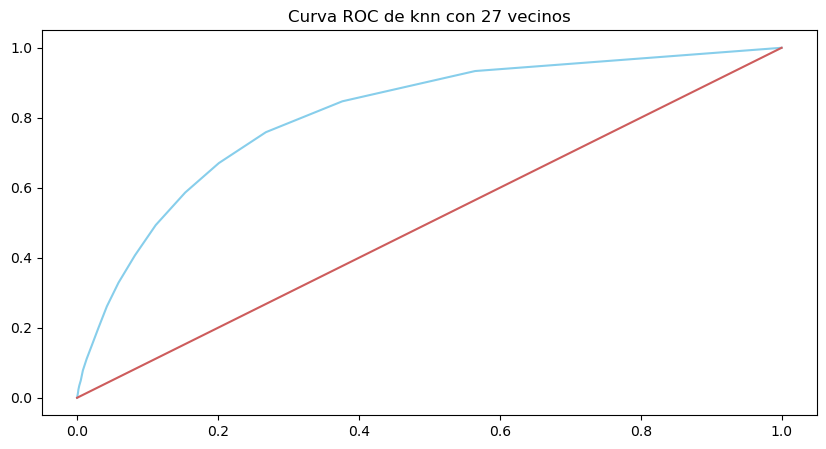

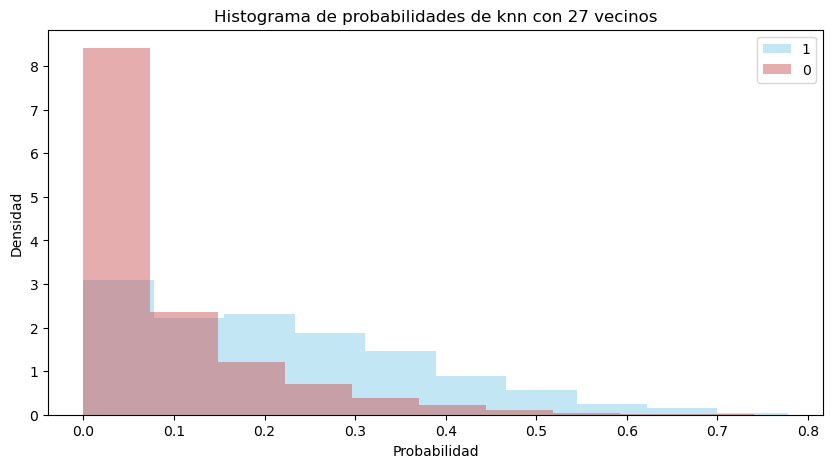

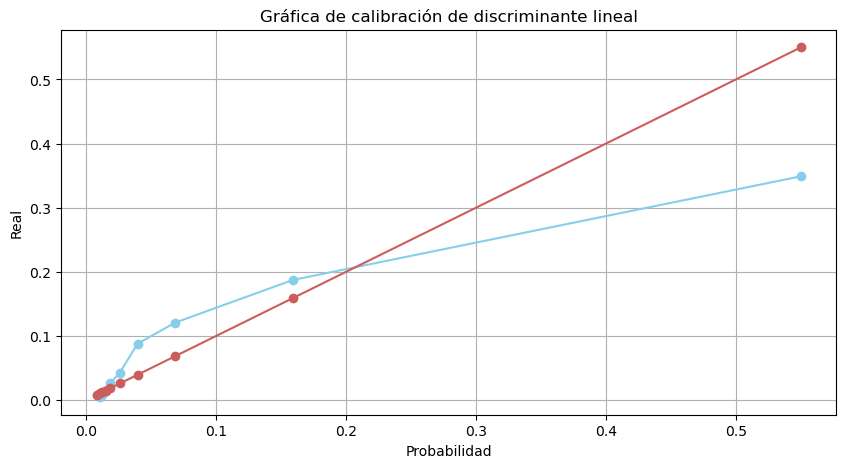

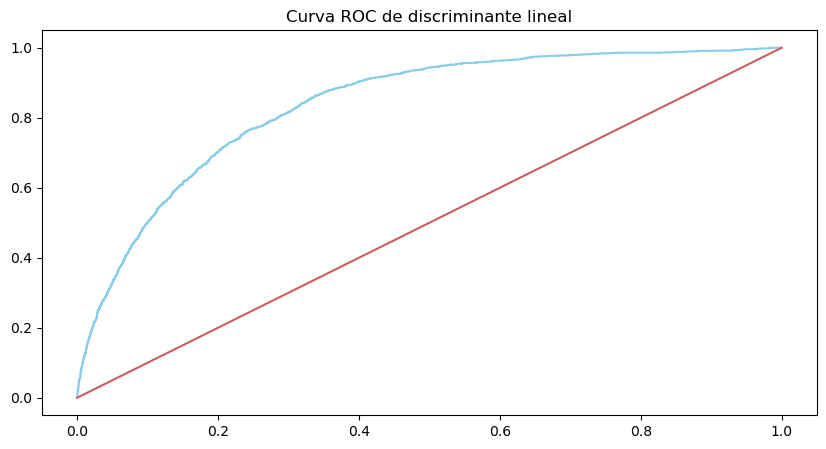

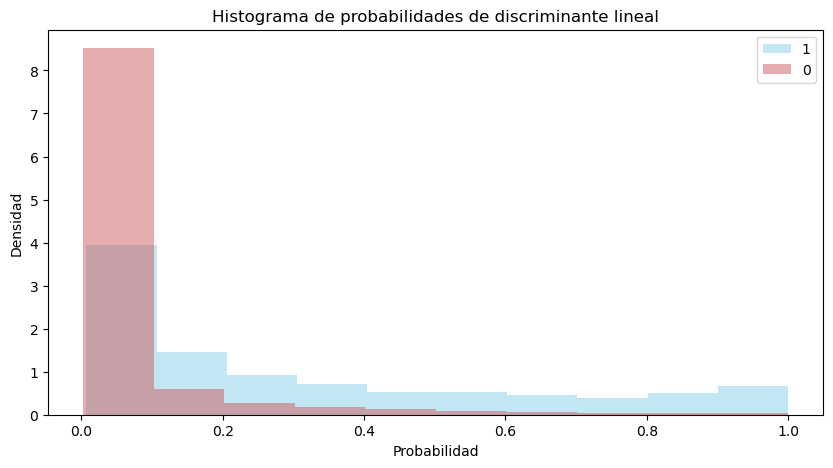

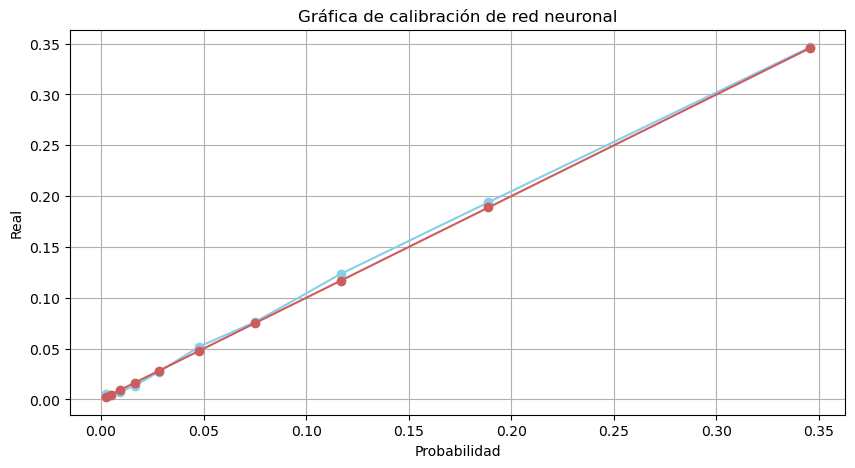

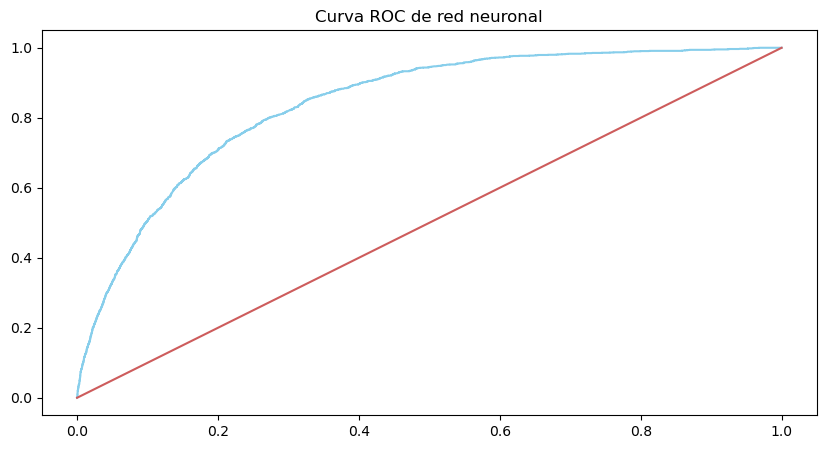

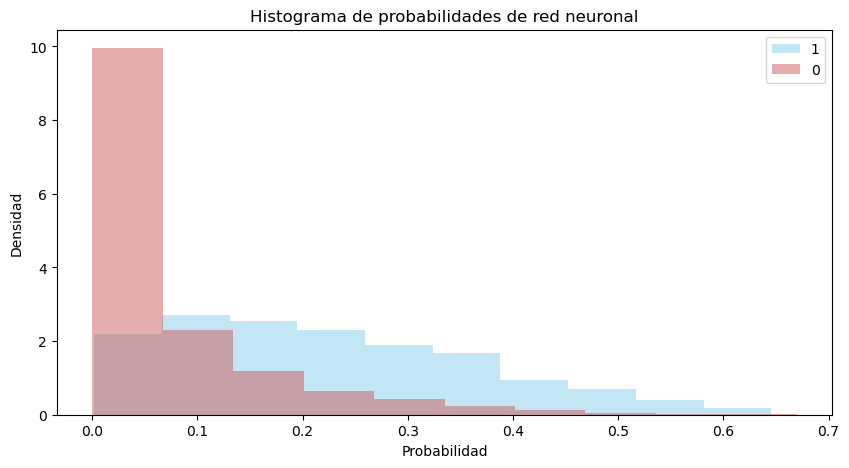

,modelos,auc,gini
0,Regresión Logística,0.839372,0.678744
1,KNN,0.808740,0.617480
2,Análisis Discriminante,0.836957,0.673914
3,Red Neuronal,0.839638,0.679277


In [17]:
models = ClassificationModels(X, y)
models.run_models()

Al correr los modelos una vez hecho el feature engineering, ninguno de los modelos supero a la regresión logística realizada anteriormente realizada, por lo que se puede intentar otra técnica de feature engineering, que es convertir las variables numéricas a categóricas.

En cuanto a los coeficientes de la regresión logística, los más importantes fueron:
- age_bmi log_bmi age^15
- smoking_history_never age^15
- age_bmi

Todos con un valor cercano a 0.45, por lo que las log-odds de tener diabetes aumentan alrededor de 0.45 por cada unidad de incremento de cada una de estas variables.

De igual forma que antes del feature enigineering, el histograma muestra predicciones muy bajas para quienes si tienen diabetes, por lo que transformar las variables numéricas a categóricas puede ser una buena idea para mejorar la capacidad del modelo.


## <font color='navy'> Variables numéricas a categóricas

In [18]:
# Crea la función de bins para las variables numéricas
def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin'] = pd.qcut(X[var], q=bins, labels=False, duplicates='drop') + 1
    return X

# Aplica la función de bins directamente a X
X = create_bins(X, numerical_features, 10)

# Identifica las nuevas variables binned y las variables categóricas restantes
bins_features = [i for i in X.columns if '_bin' in i]
cat_features = [i for i in X.columns if '_bin' not in i]

# Features finales
final_features = bins_features + cat_features

# Aplica get_dummies para crear variables dummy de los bins
X = pd.get_dummies(X[final_features], columns=bins_features, drop_first=True)

### <font color='navy'> Probar los modelos

In [19]:
models = ClassificationModels(X, y)

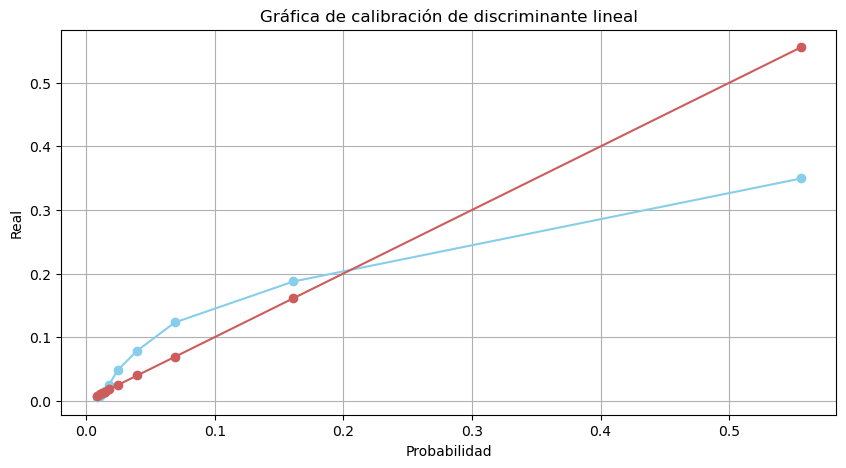

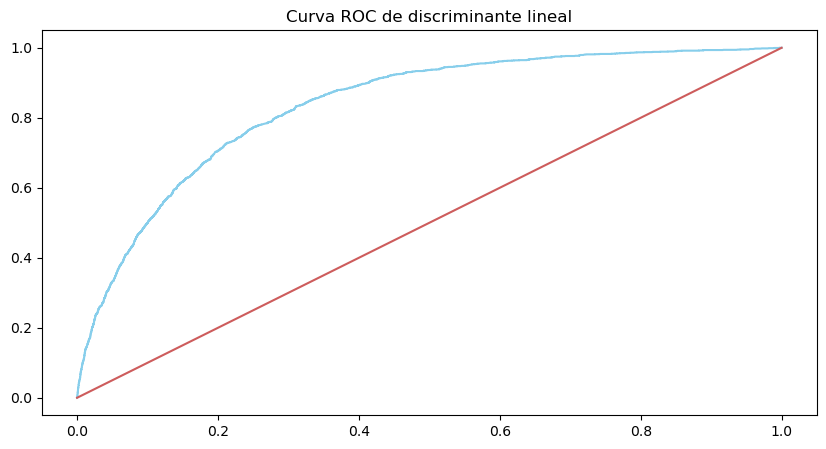

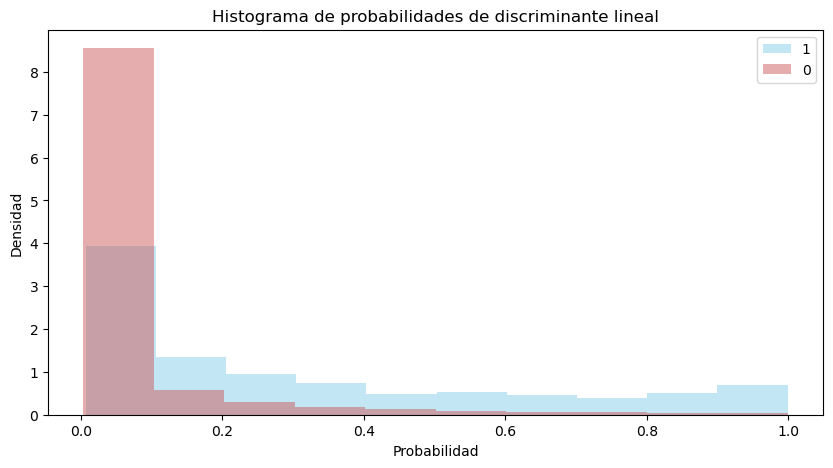

0.8357562841530055

In [20]:
models.discriminant_analysis()

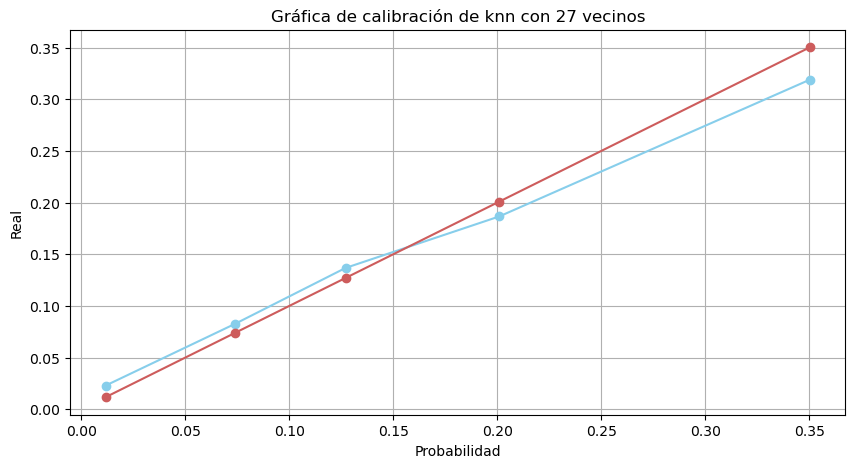

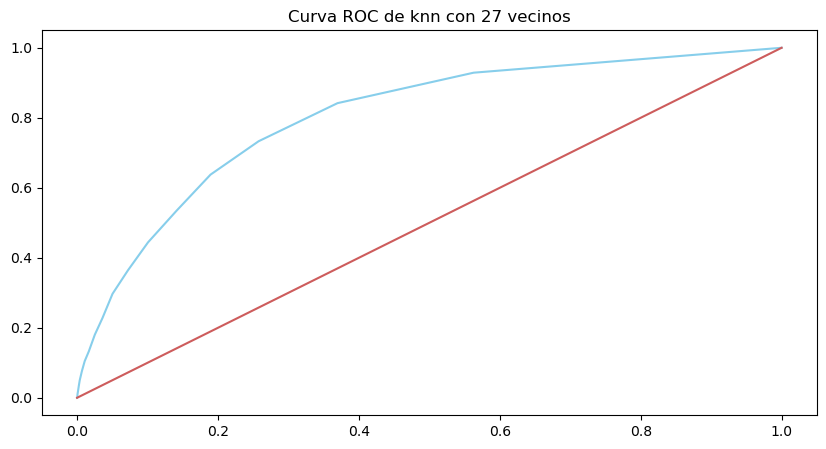

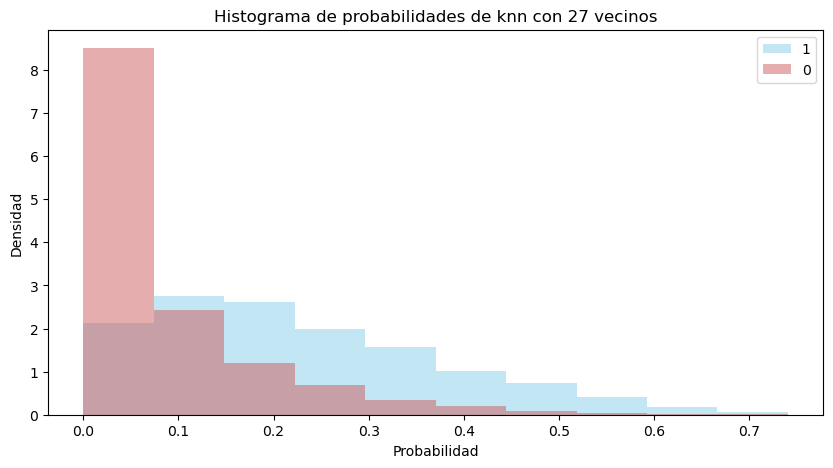

0.8030347637415621

In [21]:
models.knn_classification()

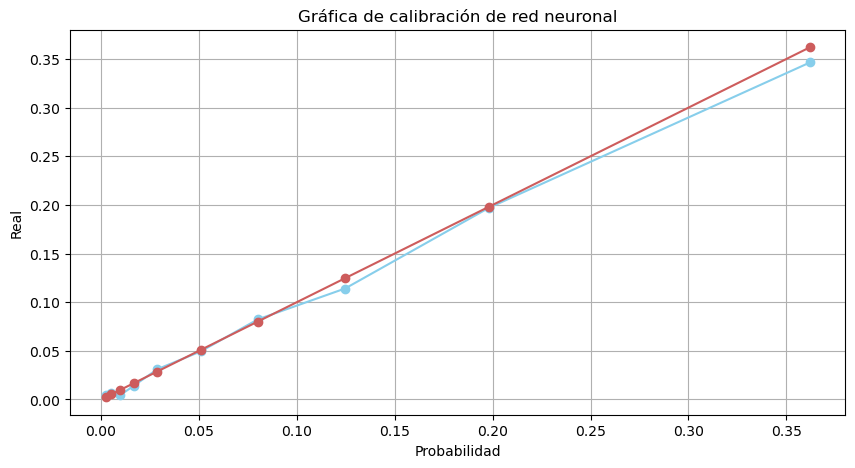

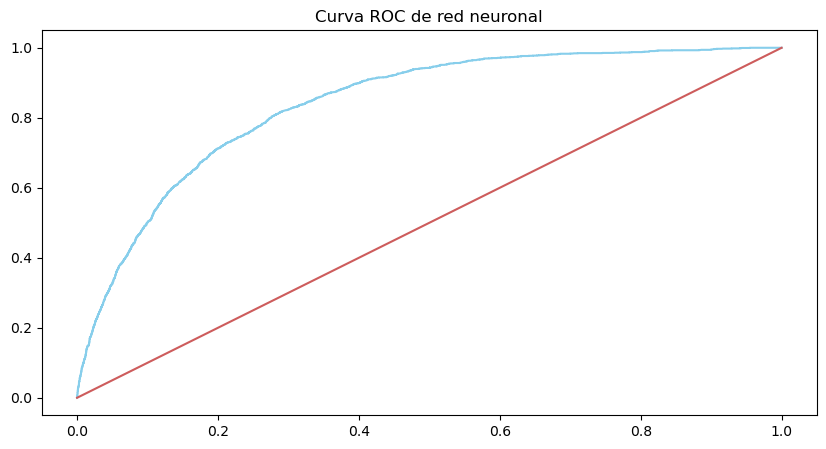

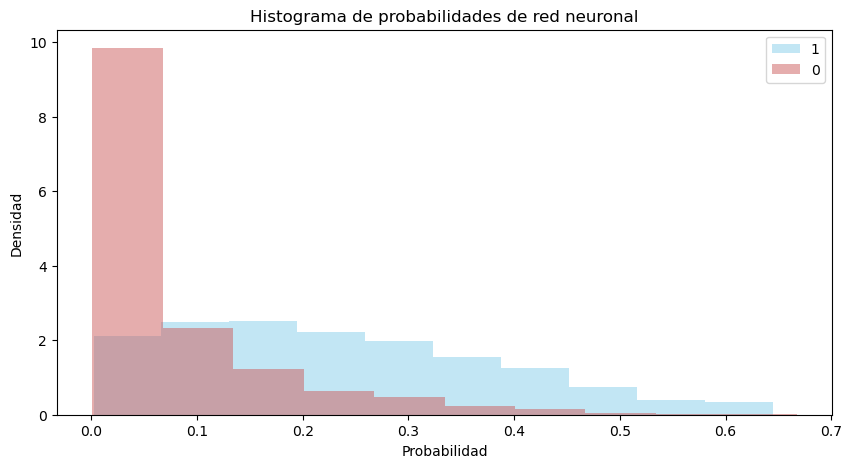

0.8397614271938284

In [22]:
models.red_neuronal()

Una vez probados los modelos los resultados del AUC indican que el mejor es la red neuronal con 0.8397, sin embargo, es inferior al modelo obtenido con nuestros datos originales usando una regresión logística de polinomio grado 2. Por lo tanto, el feature engineering realizado si bien mejoro ligeramente modelos como la red neuronal, no logró ser efectiva para obtener un AUC mayor al de la regresión logística inicial.

**Nota:** En esta sección no se hizo una regresión lineal debido a lo pesado de entrenarla por la cantidad de datos que se tiene.

## <font color='navy'> Conclusiones

In [31]:
data = pd.read_csv('diabetes.csv')
data = pd.get_dummies(data, columns=['gender', 'smoking_history'])
data['is_80'] = (data['age'] >= 80).astype(int)
target = 'diabetes'
data.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,is_80
0,80.0,0,1,25.19,0,True,False,False,False,False,False,False,True,False,1
1,54.0,0,0,27.32,0,True,False,False,True,False,False,False,False,False,0
2,28.0,0,0,27.32,0,False,True,False,False,False,False,False,True,False,0
3,36.0,0,0,23.45,0,True,False,False,False,True,False,False,False,False,0
4,76.0,1,1,20.14,0,False,True,False,False,True,False,False,False,False,0


In [32]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

,variable,coeficiente
0,age,0.754540
17,age bmi,0.718087
3,bmi,0.629773
18,age gender_Female,0.336403
19,age gender_Male,0.316991
...,...,...
63,bmi is_80,-0.209638
16,age heart_disease,-0.270230
15,age hypertension,-0.316734
53,bmi^2,-0.434138


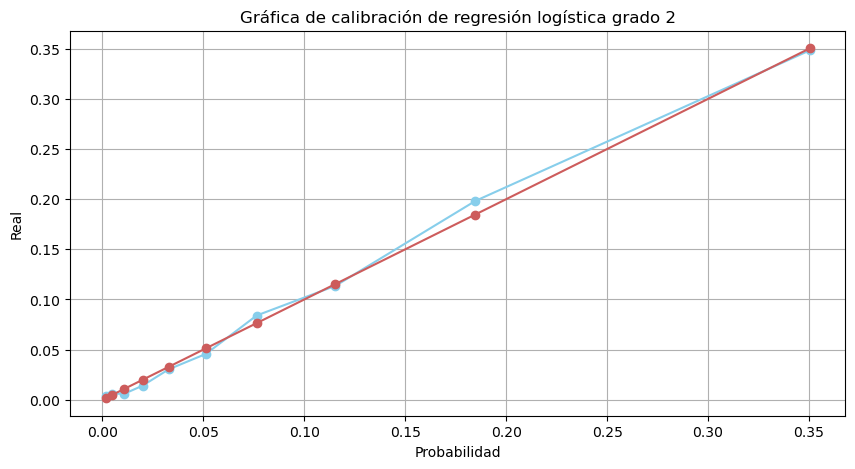

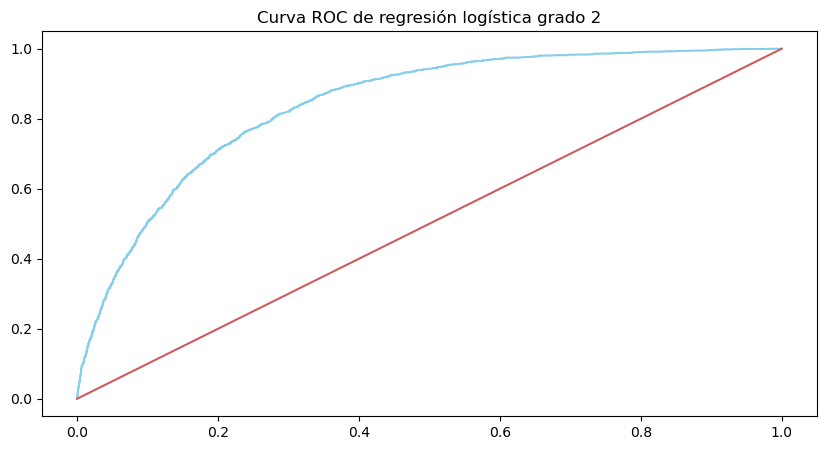

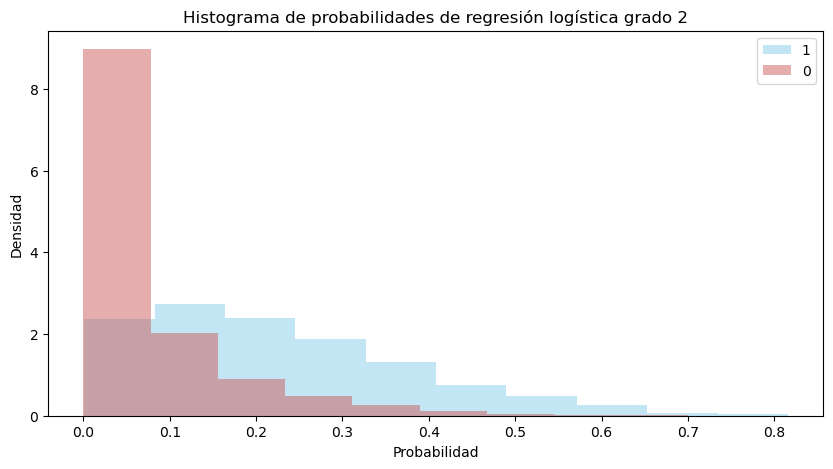

0.8402157827065252

In [33]:
models = ClassificationModels(X, y)
models.logistic_regression()

Tras haber probado distintos modelos e intentar su mejora a través de técnicas como el feature engineering y cross validation, el mejor modelo obtenido fue una regresión logística polinomial de grado 2, la cual tuvo un AUC de 0.8402. Esto significa que tiene una capacidad bastante buena para poder distinguir las clases, en este caso identificando si la persona tiene diabetes o no.

Este AUC significa que hay un 84.02% de probabilidad, de que la probabilidad predicha para alguien con diabetes sea mayor a la de alguien sin diabetes. Esto es un buen indicador ya que esperas que las predicciones de probabilidad para alguien con diebetes sean altas en comparación con las de alguien sin diabetes.

Los factores que mas influyen en la probabilidad de tener diabetes son age, age * bmi y bmi, donde a mayor cada una de estas variables el log-odds de que la persona tenga diabetes aumenta. Esto quiere decir que una mayor edad y un mayor bmi son factores importantes para determinar si una persona tiene diabetes, por lo que son dos cosas que se deben de revisar bastante.

A pesar de tener un AUC alto, el histograma nos muestra predicciones de probabilidad bastante bajas para las personas con diabetes, esto es importante tomarlo en cuenta ya que no se pudo mejorar a través de feature engineering. En general para las personas que no tienen diabetes, un 80% de las veces la predicción es menor a 0.1, por lo que en cuanto a clasificar quien no tiene diabetes es modelo es bastante efectivo.

Considerando este detalle, a final de cuentas este fue el mejor modelo que se pudo obtener. Además el AUC que obtiene es bastante alto dentro de un problema de clasificación, por lo que si es de utilidad y bastante bueno para distinguir entre clases.